d:\ana\envs\dl\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


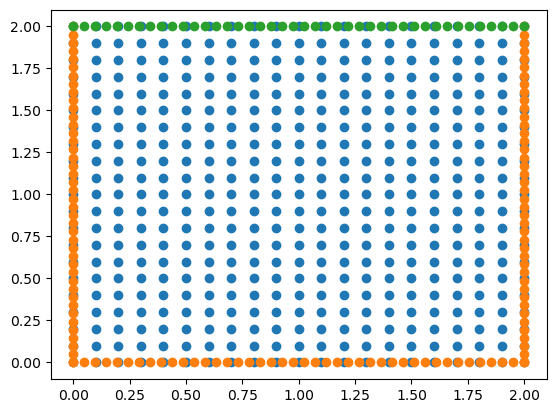

In [1]:
import sys
sys.path.append('../')

import copy

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import torch
import matplotlib

from user_funn.field import D2Field
from user_funn.get_net import ForwardNetwork
from user_funn.ds import get_data_loader
from user_funn.solver import CloudPointSolver
from user_funn.geom import line_linspace
import user_funn.plot

np.random.seed(1)
torch.manual_seed(2)

# STEP1 data generate
batch_num = 1
nx = 21

field = D2Field([0,2],[0,2])
pde_batch_size = nx * nx
pde_input = field.get_field_mesh([nx,nx])
pde_output = np.zeros([pde_batch_size,3])

points_num_per_line = nx * 2 #每条边上用点数量
bc_left_input = line_linspace([0,0],[0,2], points_num_per_line)
bc_up_input = line_linspace([0,2],[2,2], points_num_per_line)
bc_right_input = line_linspace([2,2],[2,0], points_num_per_line)
bc_down_input = line_linspace([2,0],[0,0], points_num_per_line)

bc_uv_zero_input = np.vstack([bc_left_input, bc_down_input, bc_right_input])
bc_uv_up_input = bc_up_input 


user_funn.plot.scatter_2d_cloud_point_kind([pde_input, bc_uv_zero_input, \
    bc_uv_up_input])

from user_funn.geom import add_t
time_linspace = np.arange(0,1,0.1)
tc_input = add_t(pde_input,np.array([0]))
pde_input = add_t(pde_input,time_linspace)
bc_uv_zero_input = add_t(bc_uv_zero_input,time_linspace)
bc_uv_up_input = add_t(bc_uv_up_input,time_linspace)

tc_batchsize = tc_input.shape[0]
tc_output = np.zeros([tc_batchsize,3])

pde_batchsize = pde_input.shape[0]
pde_output = np.zeros([pde_batchsize,3])

bc_uv_zero_batchsize = bc_uv_zero_input.shape[0]
bc_uv_up_batchsize = bc_uv_up_input.shape[0]
bc_uv_zero_output = np.zeros([bc_uv_zero_batchsize, 2])

bc_uv_up_output = np.zeros([bc_uv_up_batchsize, 2])
bc_uv_up_output[:,0] = np.sin(np.pi*0.5*bc_uv_up_input[:,0])


In [2]:
from user_funn.pde import diff

MU = 0.1
loss_fn = torch.nn.MSELoss()

def pde_loss(model, data):
    x_in,y_real = data
    x_in.requires_grad=True

    t = x_in[:,[0]]
    x = x_in[:,[1]]
    y = x_in[:,[2]]
    x_use = torch.cat((t,x,y),dim = 1)
    U = model(x_use)
    p = U[:,[0]]
    u = U[:,[1]]
    v = U[:,[2]]

    dudt = diff(u,t)
    dvdt = diff(v,t)
    dudx = diff(u,x)
    dudy = diff(u,y)
    dvdx = diff(v,x)
    dvdy = diff(v,y)
    dpdx = diff(p,x)
    dpdy = diff(p,y)

    du2dx2 = diff(dudx,x)
    du2dy2 = diff(dudy,y)
    dv2dx2 = diff(dvdx,x)
    dv2dy2 = diff(dvdy,y)

    eq1 = u * dudx + v * dudy + dpdx - MU * (du2dx2 + du2dy2) - dudt
    eq2 = u * dvdx + v * dvdy + dpdy - MU * (dv2dx2 + dv2dy2) - dvdt
    eq3 = dudx + dvdy
    loss_val = loss_fn(eq1, y_real[:,[0]]) + loss_fn(eq2, y_real[:,[1]]) + \
        loss_fn(eq3, y_real[:,[2]])
    return loss_val


from user_funn.bc import data_loss_factory
bc_uv_zero_loss = data_loss_factory(loss_fn, [1,2])
bc_uv_up_loss = data_loss_factory(loss_fn, [1,2])
tc_loss = data_loss_factory(loss_fn, [0,1,2])

cloud_point_data = [
    [pde_input, pde_output],
    [bc_uv_zero_input, bc_uv_zero_output],
    [bc_uv_up_input, bc_uv_up_output],
    [tc_input, tc_output]
    ]

solver = CloudPointSolver(
    cloud_point_data,
    [pde_loss, bc_uv_zero_loss, bc_uv_up_loss,tc_loss],
    model = ForwardNetwork([3, 64, 64, 64, 64, 3]),
    optimizer = "adam",
    batchsize = [pde_batchsize, bc_uv_zero_batchsize, bc_uv_up_batchsize,tc_batchsize]
    )

for i in range(5000):
    solver.train_step()
    if i % 100 == 0:
        solver.test_step(print_flag=True)
print('train over')

loss is [0.00287076 0.0015286  0.17465581 0.00323761 0.18229277]
loss is [0.00795491 0.01519682 0.03048957 0.01137975 0.06502104]
loss is [0.00696003 0.01475726 0.01590576 0.00799447 0.04561753]
loss is [0.00631489 0.01633647 0.01180693 0.00661528 0.04107358]
loss is [0.00600425 0.01498003 0.01161285 0.00558147 0.0381786 ]
loss is [0.00498114 0.01369979 0.01184808 0.00541741 0.03594641]
loss is [0.00456122 0.01407948 0.01063846 0.00518451 0.03446367]
loss is [0.00428116 0.01280011 0.0102506  0.00476203 0.03209391]
loss is [0.00435362 0.01081184 0.01010006 0.00418394 0.02944946]
loss is [0.00449753 0.01084657 0.00674918 0.00351003 0.02560331]
loss is [0.00457784 0.00921661 0.00668608 0.00280248 0.02328301]
loss is [0.00703679 0.00747242 0.01014172 0.00244123 0.02709216]
loss is [0.0032101  0.00877414 0.0033778  0.00204744 0.01740948]
loss is [0.0025042  0.00838451 0.00293565 0.00172813 0.01555248]
loss is [0.00165218 0.00824044 0.00235845 0.00167703 0.0139281 ]
loss is [0.00146519 0.007

0.8092508721103774
0.719702278061527
0.884178347800119
U error is 0.7777760177770904


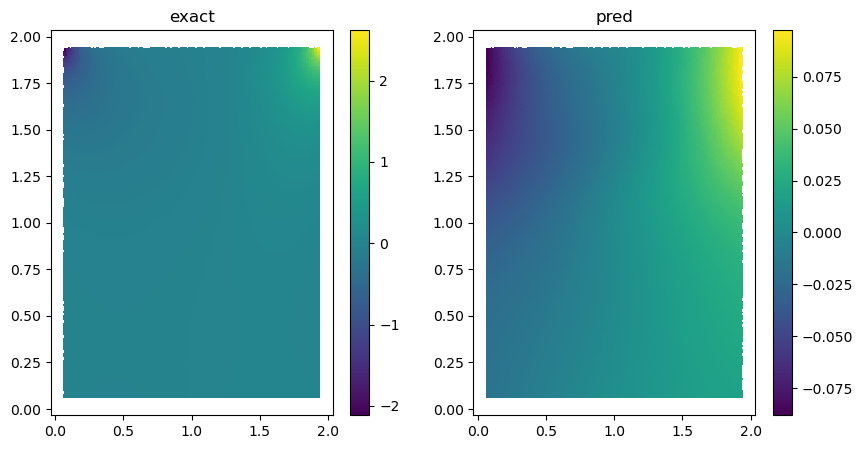

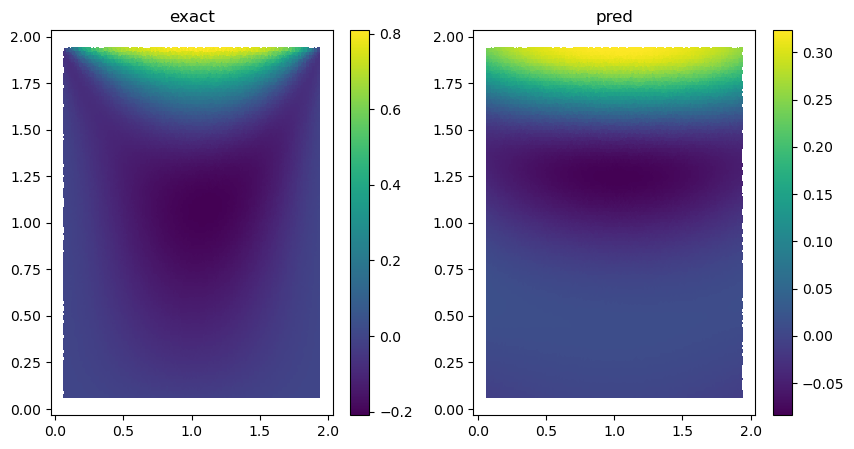

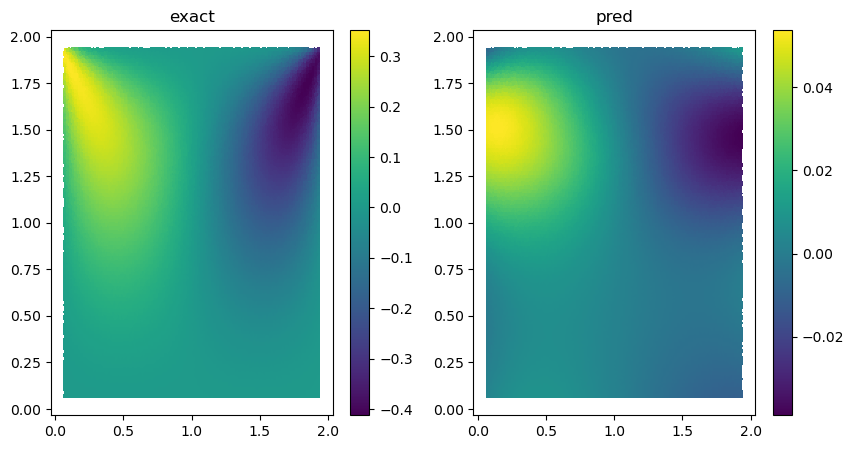

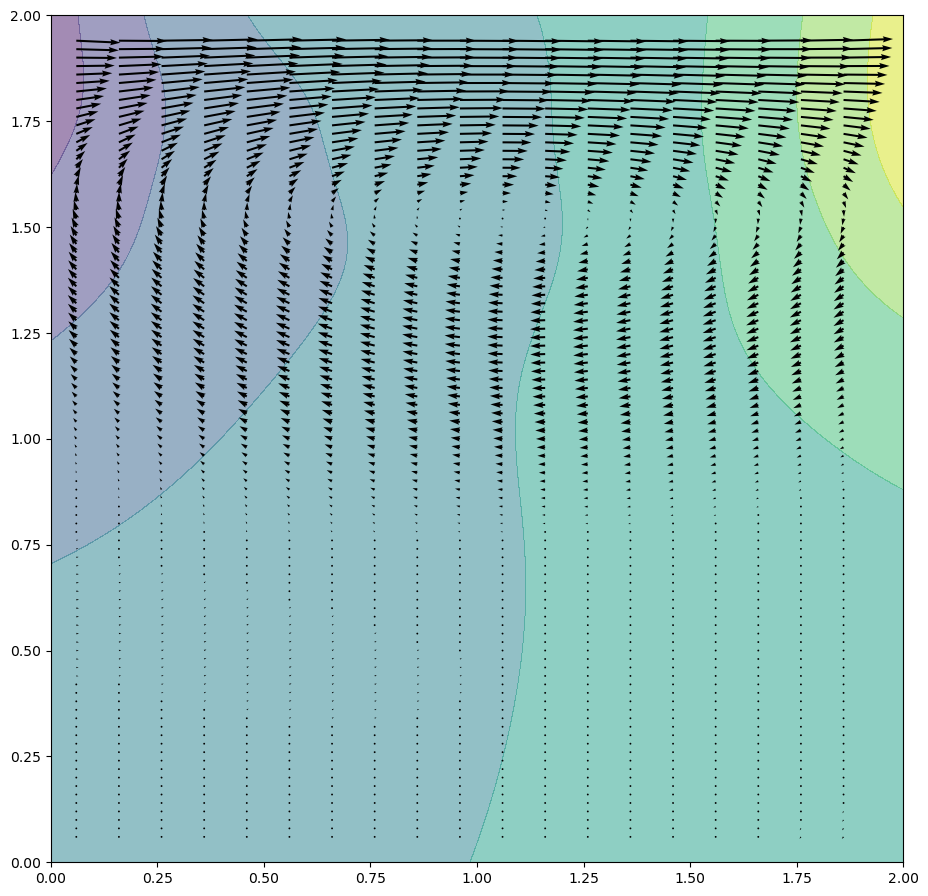

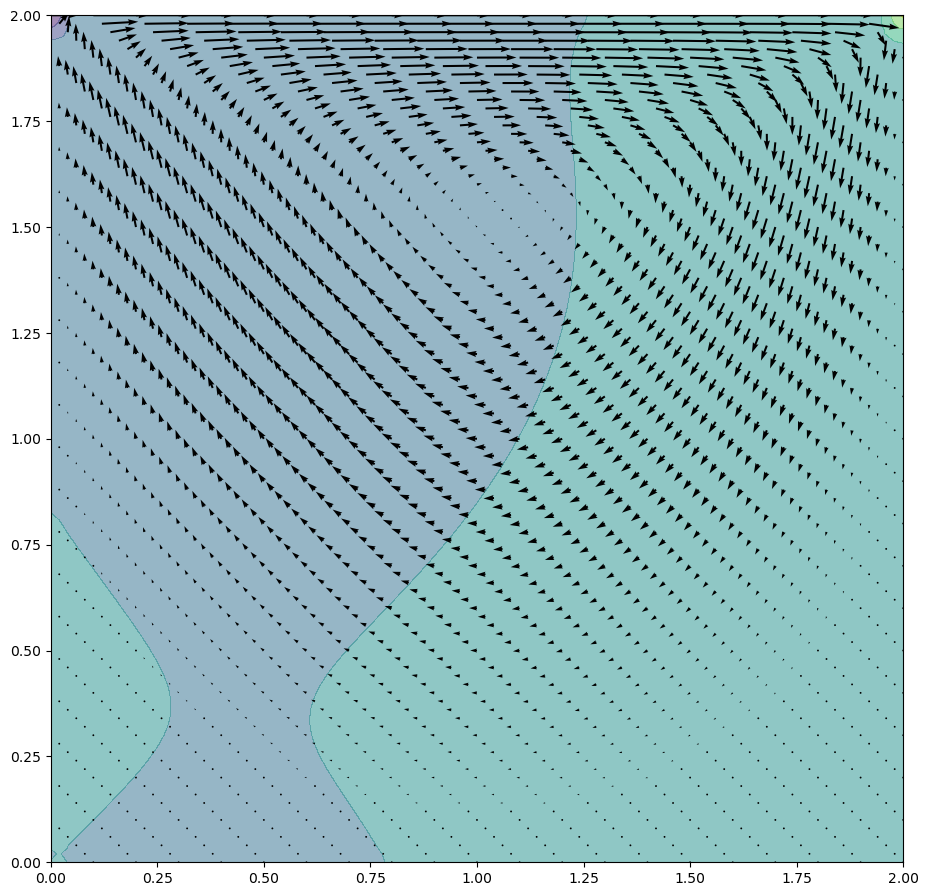

In [5]:
from user_funn.paraview_read import read2D_paraview_csv
exact_x,exact_y,exact_p,exact_u,exact_v=read2D_paraview_csv('../data/t=5,nu=0.1all_result.csv',5)
filter = (exact_x>=0.05) & (exact_x<=1.95) & (exact_y>=0.05) & (exact_y<=1.95) 

plot_input = np.array([exact_x,exact_y]).T
plot_output = solver.model_eval(add_t(plot_input,np.array([0.2])))
plot_p = plot_output[:,0]
plot_u = plot_output[:,1]
plot_v = plot_output[:,2]

import matplotlib.pyplot as plt
import matplotlib.tri as tri

def plot_U(x,y,u_exact,u_pred):
    fig,(ax1,ax2) = plt.subplots(1,2,figsize =[10,5] )

    triang = tri.Triangulation(x,y)
    tpc = ax1.tripcolor(triang,u_exact , shading='flat')
    fig.colorbar(tpc,ax=ax1)
    ax1.set_title('exact')

    tpc = ax2.tripcolor(triang,u_pred , shading='flat')
    fig.colorbar(tpc,ax=ax2)
    ax2.set_title('pred')
    print(np.mean(np.abs(u_exact-u_pred))/np.mean(np.abs(u_exact)))

x = plot_input[:,0]
y = plot_input[:,1]
plot_U(plot_input[filter,0], plot_input[filter,1], \
    exact_p[filter]-np.mean(exact_p), plot_p[filter]-np.mean(plot_p))
plot_U(plot_input[filter,0], plot_input[filter,1], \
    exact_u[filter], plot_u[filter])
plot_U(plot_input[filter,0], plot_input[filter,1], \
    exact_v[filter], plot_v[filter])

plot_x = plot_input[:,0]
plot_y = plot_input[:,1]
plt.figure(figsize=(11, 11))
plt.tricontourf(plot_x, plot_y, plot_p,alpha=0.5, cmap=cm.viridis)
plt.quiver(plot_x[filter][::5], plot_y[filter][::5],plot_u[filter][::5],plot_v[filter][::5])

plt.figure(figsize=(11, 11))
plt.tricontourf(plot_x, plot_y, exact_p,alpha=0.5, cmap=cm.viridis)
plt.quiver(plot_x[::5], plot_y[::5],exact_u[::5],exact_v[::5])

def calc_U_error(exact_u,pred_u,exact_v,pred_v):
    error_u = np.abs(exact_u-pred_u)
    error_v = np.abs(exact_v-pred_v)
    error_U = np.sqrt(error_u**2 + error_v**2)
    org_U = np.sqrt(exact_u**2 + exact_v**2)
    return error_U/np.mean(org_U)

print('U error is', np.mean(calc_U_error(exact_u,plot_u,exact_v,plot_v)))

time is [0.2]
error p:0.04735075522932904
error U:0.05238926227211146
time is [0.4]
error p:0.055929760590903994
error U:0.059473400706801856
time is [0.6]
error p:0.058619527683263374
error U:0.06358804920407428
time is [0.8]
error p:0.05498989799623244
error U:0.08404552829888068
time is [1.]
error p:0.0483561873030904
error U:0.1506479373307543


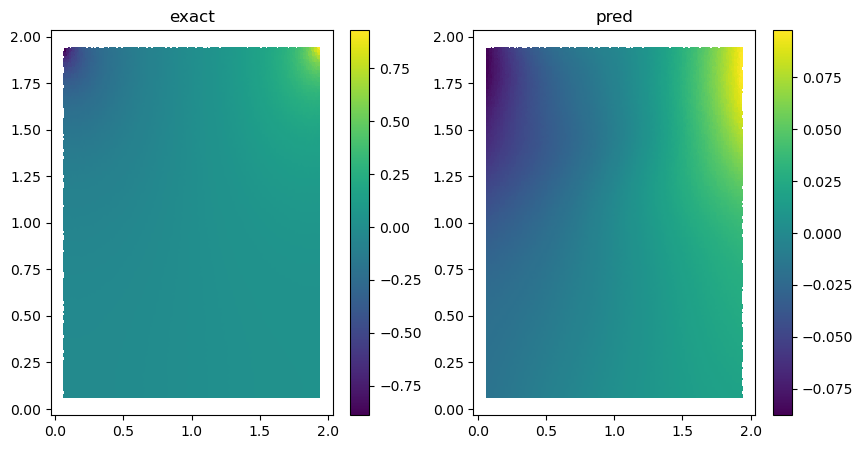

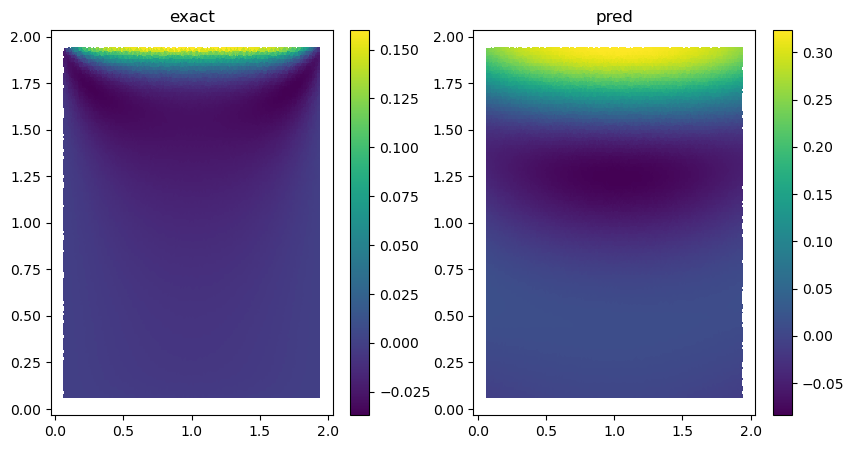

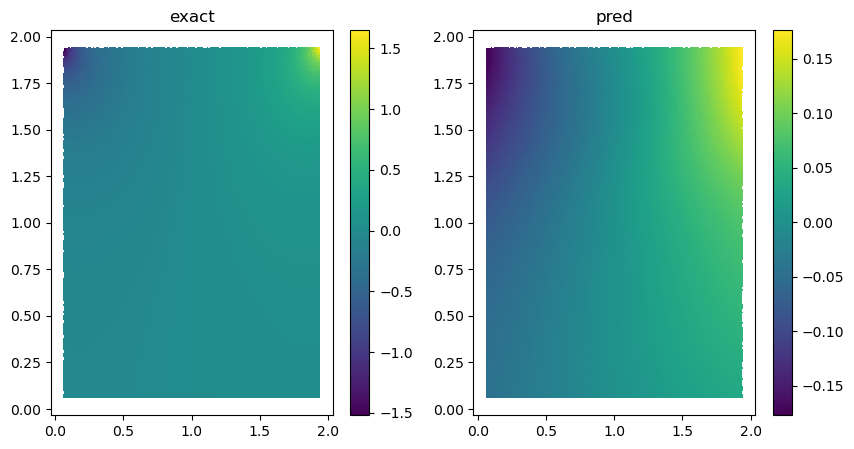

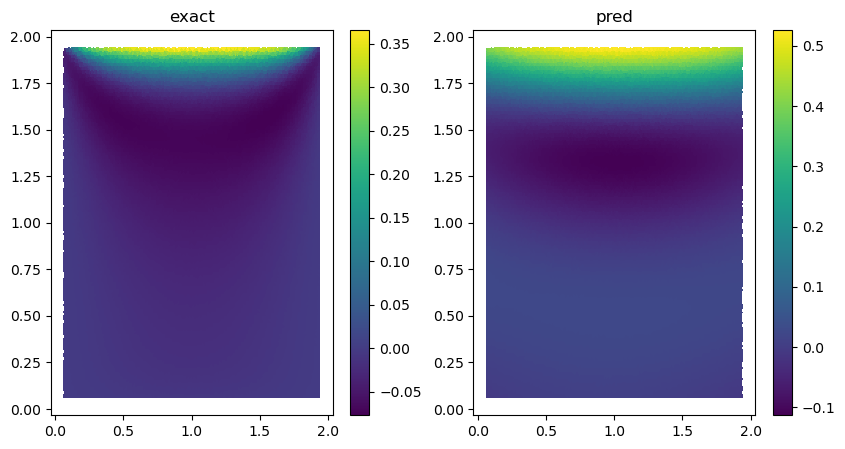

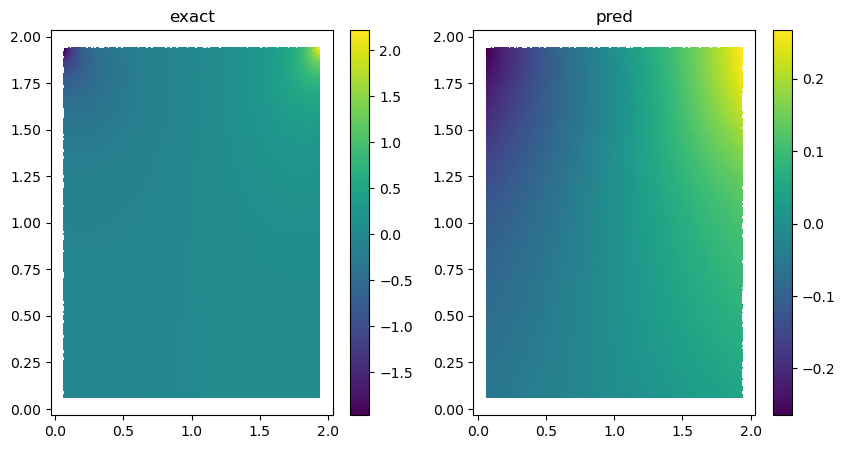

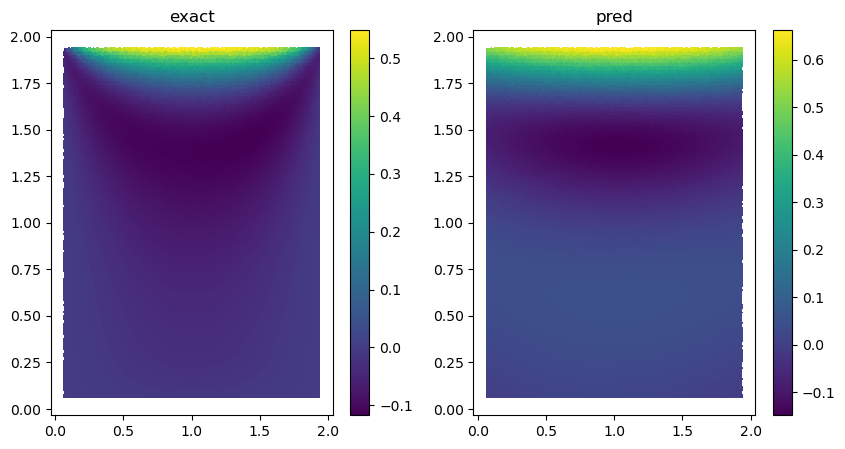

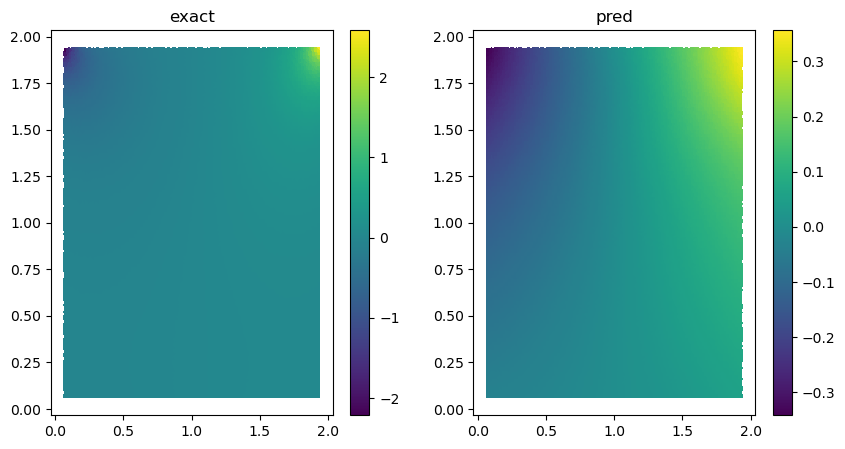

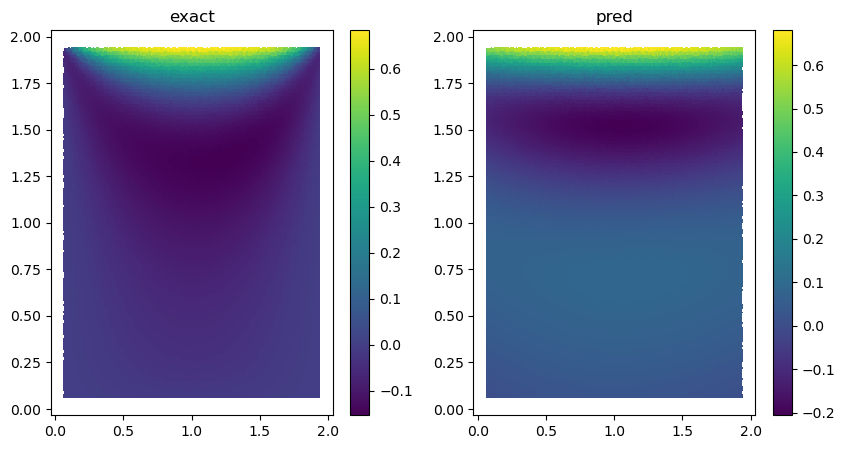

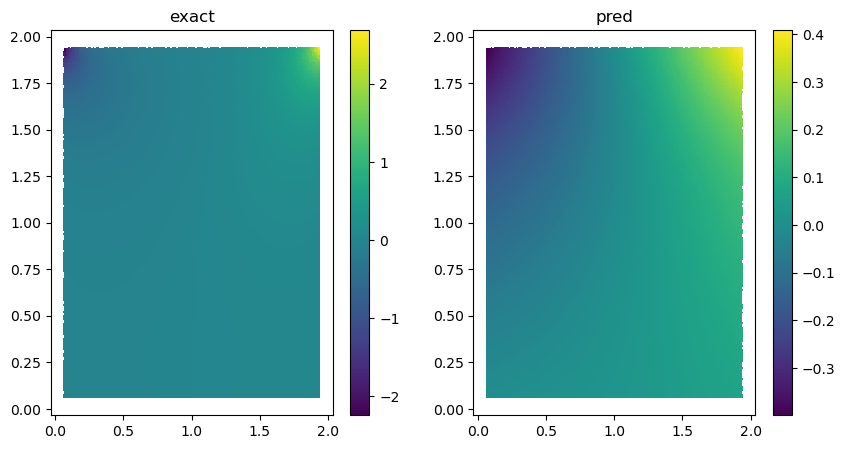

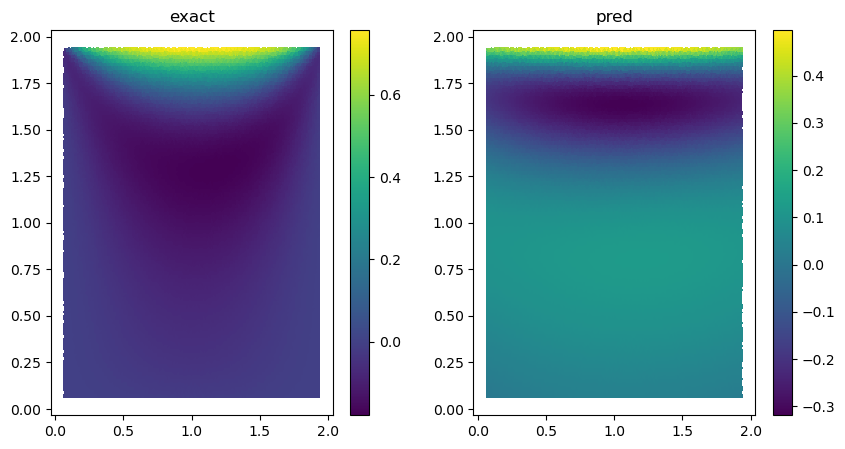

In [7]:
import matplotlib.pyplot as plt
import matplotlib.tri as tri

def read_comsol_result(filename = 'result.txt',nx = 101):
    result = np.loadtxt(filename)
    x = result[:,0]
    y = result[:,1]
    k = 2
    p,u,v,time = [],[],[],[]
    for t in np.arange(0.0, 2.01, 0.1):
        p.append( result[:,k] ) 
        k = k+1
        u.append( result[:,k] )
        k = k+1
        v.append( result[:,k] )
        k = k+1
        time.append(t)
    return x,y,p,u,v,time

def plot_U(x,y,u_exact,u_pred):
    fig,(ax1,ax2) = plt.subplots(1,2,figsize =[10,5] )

    triang = tri.Triangulation(x,y)
    tpc = ax1.tripcolor(triang,u_exact , shading='flat')
    fig.colorbar(tpc,ax=ax1)
    ax1.set_title('exact')

    tpc = ax2.tripcolor(triang,u_pred , shading='flat')
    fig.colorbar(tpc,ax=ax2)
    ax2.set_title('pred')
    print(np.mean(np.abs(u_exact-u_pred)))

x,y,p,u,v,t = read_comsol_result()
filter = (x>=0.05) & (x<=1.95) & (y>=0.05) & (y<=1.95)
x_f,y_f = x[filter],y[filter]
#x_f,y_f = np.expand_dims(x[filter],axis = 1),np.expand_dims(y[filter],axis = 1)
for i in range(2,11,2):
    # fig,ax = plt.subplots()
    # triang = tri.Triangulation(x[filter],y[filter])
    # tpc = ax.tripcolor(triang, p[i][filter] , shading='flat')
    time_now = np.array(t[i]).reshape(1)
    plot_input = add_t(np.array([x_f,y_f]).T, time_now)
    plot_output = solver.model_eval(plot_input)
    plot_p = plot_output[:,0]
    plot_u = plot_output[:,1]
    plot_v = plot_output[:,2]
    print(f'time is {time_now}')
    print('error p:', end= '')
    plot_U(x_f, y_f, p[i][filter]-np.mean(p[i][filter]), plot_p-np.mean(plot_p))
    print('error U:', end= '')
    plot_U(x_f, y_f, u[i][filter], plot_u)
